In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import  Conv2D ,MaxPool2D
from keras.layers import Activation,Dropout,Flatten, Dense
from keras import backend as k
import numpy as np
from keras.preprocessing import image
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
import pandas as pd
import tensorflow as tf
import time

Using TensorFlow backend.


# Setting up training and testing data

In [2]:
train_dir = "C:/Users/david/Desktop/train2"
test_dir= "C:/Users/david/Desktop/tutu"

IMG_SIZE = (150, 150)

In [3]:
labels = []
img_path = []
path= 'C:/Users/david/Desktop/train2/'
for img in os.listdir(train_dir):
    img_path.append(os.path.join(path,img))
    
    if img.startswith("cat"):
        labels.append("cat")
    elif img.startswith("dog"):
        labels.append("dog")

In [4]:
df = pd.DataFrame({
    'image' : img_path,
    'class' : labels
})

# Softmax

In [5]:
train_datagen = ImageDataGenerator(validation_split = 0.2, rescale = 1. / 255)
train_generator = train_datagen.flow_from_dataframe(dataframe = df, 
                                                    x_col = 'image', 
                                                    y_col = 'class', 
                                                    batch_size = 64, 
                                                    seed = 11, 
                                                    class_mode = 'categorical', 
                                                    target_size = IMG_SIZE,
                                                    shuffle = True,
                                                    subset="training"
                                                   )

val_generator = train_datagen.flow_from_dataframe(dataframe = df, 
                                                    x_col = 'image', 
                                                    y_col = 'class', 
                                                    batch_size = 64, 
                                                    seed = 11, 
                                                    class_mode = 'categorical', 
                                                    target_size = IMG_SIZE,
                                                    shuffle = True,
                                                    subset="validation"
                                                   )

Found 2000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


# SIGMOID

In [13]:
train_datagen = ImageDataGenerator(validation_split = 0.2, rescale = 1. / 255)
train_generator = train_datagen.flow_from_dataframe(dataframe = df, 
                                                    x_col = 'image', 
                                                    y_col = 'class', 
                                                    batch_size = 64, 
                                                    seed = 11, 
                                                    class_mode = 'binary', 
                                                    target_size = IMG_SIZE,
                                                    shuffle = True,
                                                    subset="training"
                                                   )

val_generator = train_datagen.flow_from_dataframe(dataframe = df, 
                                                    x_col = 'image', 
                                                    y_col = 'class', 
                                                    batch_size = 64, 
                                                    seed = 11, 
                                                    class_mode = 'binary', 
                                                    target_size = IMG_SIZE,
                                                    shuffle = True,
                                                    subset="validation" 
                                                   )

Found 2000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [6]:
train_steps = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size

# Building model

In [7]:
from keras.applications import DenseNet201

base_model = DenseNet201(include_top=False, weights="imagenet",  input_shape=(150,150,3), pooling='avg' )

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
model = Sequential([
base_model,

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(),

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(),


    
Dense(2, activation='softmax')])


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               983552    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)              

In [14]:
model = Sequential([
base_model,

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(),

Dense(512, activation='relu'),
Dropout(0.25),
BatchNormalization(),


    
Dense(1, activation='sigmoid')])


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 1920)              18321984  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               983552    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)              

In [17]:
model.compile(optimizer='Nadam',loss='binary_crossentropy',metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=10)

lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3,verbose=1, factor=0.25, min_lr=0.0001)

epochs = 10

In [15]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model_nadam_densenet_sigmo.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

# Softmax

In [12]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch= 10, epochs=epochs, callbacks = [es, lr, checkpoint],
                    validation_data = val_generator,validation_steps = validation_steps, max_queue_size=100, verbose=1)

Epoch 1/10
10/10 [==============================] - 65s 6s/step - loss: 0.3922 - accuracy: 0.8281 - val_loss: 0.4102 - val_accuracy: 0.9085

Epoch 00001: val_accuracy improved from -inf to 0.90848, saving model to best_model_nadam_densenet532532.hdf5
Epoch 2/10
10/10 [==============================] - 58s 6s/step - loss: 0.1794 - accuracy: 0.9391 - val_loss: 0.0856 - val_accuracy: 0.9771

Epoch 00002: val_accuracy improved from 0.90848 to 0.97706, saving model to best_model_nadam_densenet532532.hdf5
Epoch 3/10
10/10 [==============================] - 55s 6s/step - loss: 0.2201 - accuracy: 0.9274 - val_loss: 0.0223 - val_accuracy: 0.9656

Epoch 00003: val_accuracy did not improve from 0.97706
Epoch 4/10
10/10 [==============================] - 58s 6s/step - loss: 0.1221 - accuracy: 0.9406 - val_loss: 0.1002 - val_accuracy: 0.9725

Epoch 00004: val_accuracy did not improve from 0.97706
Epoch 5/10
10/10 [==============================] - 56s 6s/step - loss: 0.0808 - accuracy: 0.9780 - val

# Sigmoid

In [18]:
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch= 10, epochs=epochs, callbacks = [es, lr, checkpoint],
                    validation_data = val_generator,validation_steps = validation_steps, max_queue_size=100, verbose=1)

Epoch 1/10
10/10 [==============================] - 66s 7s/step - loss: 0.3414 - accuracy: 0.8469 - val_loss: 0.3010 - val_accuracy: 0.9174

Epoch 00001: val_accuracy improved from -inf to 0.91741, saving model to best_model_nadam_densenet_sigmo.hdf5
Epoch 2/10
10/10 [==============================] - 56s 6s/step - loss: 0.1844 - accuracy: 0.9291 - val_loss: 0.0611 - val_accuracy: 0.9679

Epoch 00002: val_accuracy improved from 0.91741 to 0.96789, saving model to best_model_nadam_densenet_sigmo.hdf5
Epoch 3/10
10/10 [==============================] - 58s 6s/step - loss: 0.1936 - accuracy: 0.9266 - val_loss: 0.0022 - val_accuracy: 0.9679

Epoch 00003: val_accuracy did not improve from 0.96789
Epoch 4/10
10/10 [==============================] - 58s 6s/step - loss: 0.1530 - accuracy: 0.9469 - val_loss: 0.0561 - val_accuracy: 0.9587

Epoch 00004: val_accuracy did not improve from 0.96789
Epoch 5/10
10/10 [==============================] - 57s 6s/step - loss: 0.0822 - accuracy: 0.9656 - val

# Inspecting results and predictions on test data

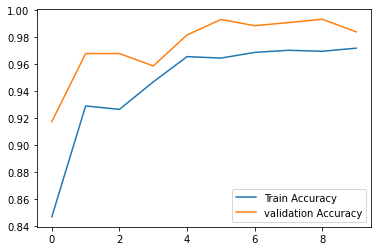

In [19]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))


plt.plot(epochs, train_acc, label = 'Train Accuracy')
plt.plot(epochs, val_acc, label = 'validation Accuracy')
plt.legend(loc=0)

plt.show()

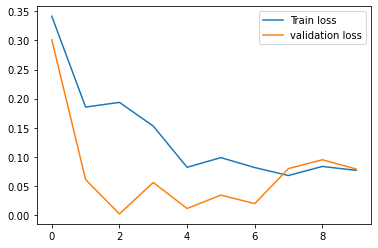

In [20]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']




plt.plot(epochs, train_loss, label = 'Train loss')
plt.plot(epochs, val_loss, label = 'validation loss')
plt.legend(loc=0)
plt.show()

In [48]:
import random

TEST_DIR = 'C:/Users/david/Desktop/tutu/'

ROWS = 150
COLS = 150
CHANNELS = 3

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]
test_images =  test_images[:]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

test = prep_data(test_images)

print("Test shape: {}".format(test.shape))

Processed 0 of 400
Processed 250 of 400
Test shape: (400, 3, 150, 150)


In [49]:
test = np.moveaxis(test, 1, -1)

In [36]:
predictions = model.predict(test,steps = 2, verbose= 1)

2/2 [==============================] - 60s 30s/step


I am 100.00% sure this is a Dog


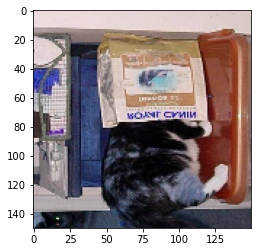

I am 100.00% sure this is a Dog


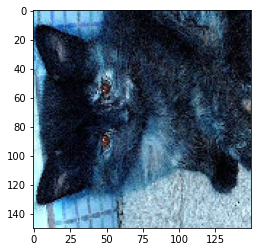

I am 100.00% sure this is a Dog


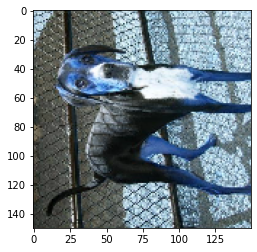

I am 100.00% sure this is a Dog


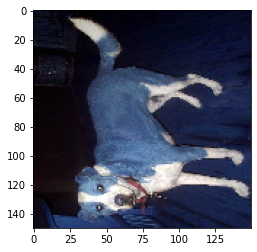

I am 100.00% sure this is a Dog


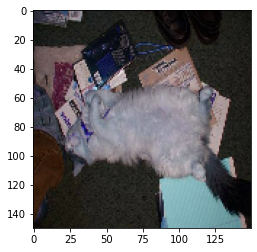

I am 95.58% sure this is a Cat


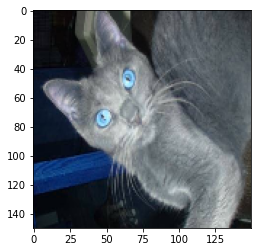

I am 100.00% sure this is a Dog


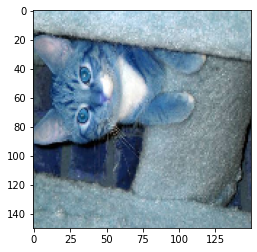

I am 99.86% sure this is a Cat


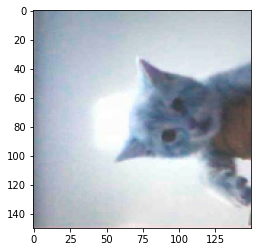

I am 100.00% sure this is a Cat


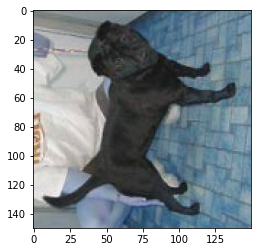

I am 100.00% sure this is a Dog


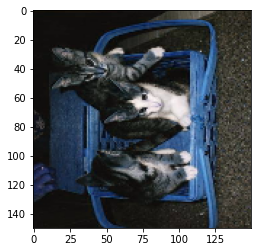

I am 100.00% sure this is a Dog


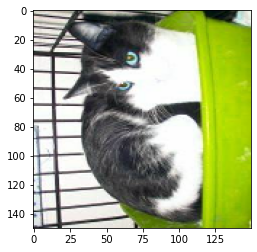

I am 100.00% sure this is a Cat


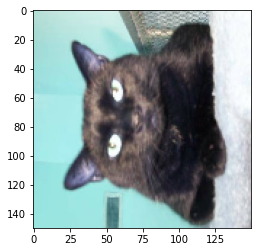

I am 99.92% sure this is a Dog


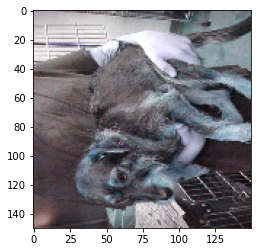

I am 71.27% sure this is a Cat


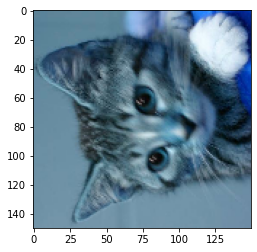

I am 100.00% sure this is a Cat


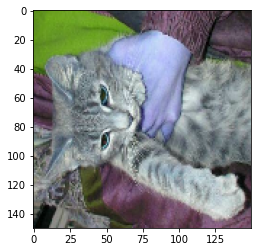

I am 100.00% sure this is a Dog


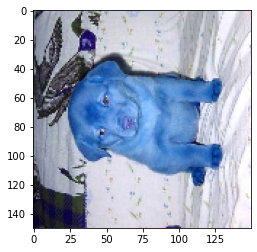

I am 61.87% sure this is a Dog


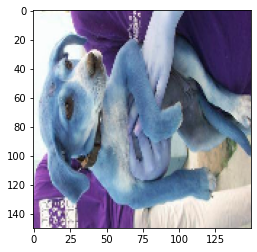

I am 99.91% sure this is a Cat


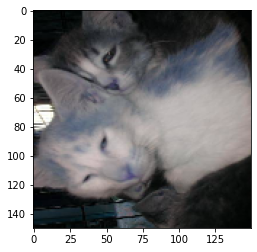

I am 98.68% sure this is a Dog


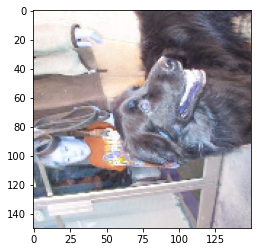

I am 100.00% sure this is a Dog


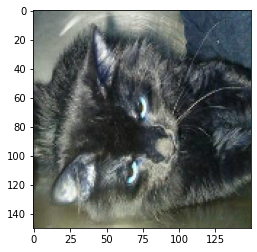

In [58]:
for i in range(50,70):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
    plt.imshow(test[i])
    plt.show()